<a href="https://colab.research.google.com/github/rh2098ta/Captstone_module23/blob/main/A_capstone_mod23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path('.')
FIG_DIR = Path('./figures')
FIG_DIR.mkdir(exist_ok=True)

In [2]:
races = pd.read_csv(DATA_DIR/'races.csv')
results = pd.read_csv(DATA_DIR/'results.csv')
drivers = pd.read_csv(DATA_DIR/'drivers.csv')
constructors = pd.read_csv(DATA_DIR/'constructors.csv')

for name, df in {"races": races, "results": results, "drivers": drivers, "constructors": constructors}.items():
    print(name, df.shape)
    display(df.head(3))


races (1125, 18)


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


results (26759, 18)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1


drivers (861, 9)


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg


constructors (212, 5)


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...


In [3]:
Xy = (results
      .merge(races[['raceId','year','round','circuitId','name','date']], on='raceId', how='left')
      .merge(drivers[['driverId','driverRef','dob']], on='driverId', how='left')
      .merge(constructors[['constructorId','name']].rename(columns={'name':'constructor_name'}),
             on='constructorId', how='left'))

Xy['podium'] = (Xy['positionOrder'] <= 3).astype(int)

Xy = Xy.sort_values(['driverId','year','round','raceId']).reset_index(drop=True)

Xy['driver_starts_so_far'] = Xy.groupby('driverId').cumcount()

driver_prev_podium = Xy.groupby('driverId')['podium'].shift(1).fillna(0).astype(int)

Xy['driver_podiums_so_far'] = driver_prev_podium.groupby(Xy['driverId']).cumsum()

Xy['driver_podium_rate_so_far'] = np.where(
    Xy['driver_starts_so_far'] > 0,
    Xy['driver_podiums_so_far'] / Xy['driver_starts_so_far'],
    0.0
)

Xy['team_starts_so_far'] = Xy.groupby('constructorId').cumcount()

team_prev_podium = Xy.groupby('constructorId')['podium'].shift(1).fillna(0).astype(int)
Xy['team_podiums_so_far'] = team_prev_podium.groupby(Xy['constructorId']).cumsum()

Xy['team_podium_rate_so_far'] = np.where(
    Xy['team_starts_so_far'] > 0,
    Xy['team_podiums_so_far'] / Xy['team_starts_so_far'],
    0.0
)

features = [
    'grid', 'year',
    'driver_starts_so_far', 'driver_podium_rate_so_far',
    'team_starts_so_far',   'team_podium_rate_so_far'
]

model_df = Xy.dropna(subset=['positionOrder'])[features + ['podium','raceId','driverId','constructorId']].copy()
model_df.head()


,grid,year,driver_starts_so_far,driver_podium_rate_so_far,team_starts_so_far,team_podium_rate_so_far,podium,raceId,driverId,constructorId
0,4,2007,0,0.0,0,0.0,1,36,1,1
1,4,2007,1,1.0,1,1.0,1,37,1,1
2,2,2007,2,1.0,2,1.0,1,38,1,1
3,4,2007,3,1.0,3,1.0,1,39,1,1
4,2,2007,4,1.0,4,1.0,1,40,1,1


,missing_rate
grid,0.0
year,0.0
driver_starts_so_far,0.0
driver_podium_rate_so_far,0.0
team_starts_so_far,0.0
team_podium_rate_so_far,0.0
podium,0.0
raceId,0.0
driverId,0.0
constructorId,0.0


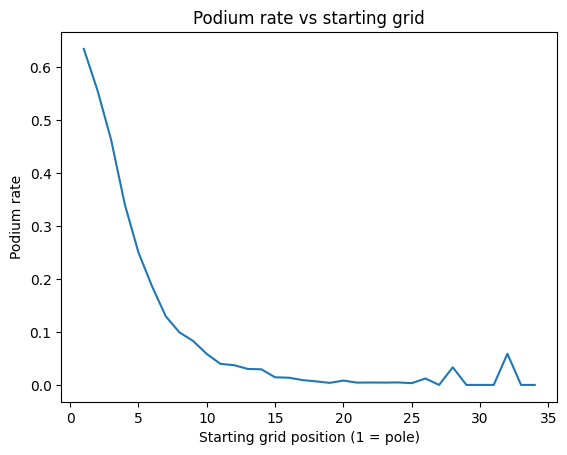

In [4]:
# Missingness bar (top 20 by missing rate)
miss = model_df.isna().mean().sort_values(ascending=False)
display(miss.to_frame('missing_rate').head(20))

# Podium rate vs grid (1 = pole). Grid 0 means pit lane/unknown; drop for this plot
tmp = Xy[Xy['grid']>=1].copy()
tmp['is_podium'] = (tmp['positionOrder']<=3).astype(int)
grid_podium = tmp.groupby('grid')['is_podium'].mean().reset_index()

plt.figure()
plt.plot(grid_podium['grid'], grid_podium['is_podium'])
plt.xlabel('Starting grid position (1 = pole)')
plt.ylabel('Podium rate')
plt.title('Podium rate vs starting grid')
plt.savefig(FIG_DIR/'podium_rate_vs_grid.png', bbox_inches='tight')
plt.show()


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

# Train on older seasons, test on newer seasons (prevents time leakage)
year_cut = int(np.quantile(model_df['year'], 0.8))
train = model_df[model_df['year'] <= year_cut]
test  = model_df[model_df['year'] >  year_cut]

X_train = train[features]
y_train = train['podium'].astype(int)
X_test  = test[features]
y_test  = test['podium'].astype(int)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print('ROC-AUC:', round(roc_auc_score(y_test, proba), 3))
print('Accuracy:', round(accuracy_score(y_test, pred), 3))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))


ROC-AUC: 0.918
Accuracy: 0.892
Confusion matrix:
 [[4099  204]
 [ 339  402]]


In [6]:
test_with_pred = test.assign(pred_proba=proba)

def top3_hit_rate(df):
    top3 = df.sort_values('pred_proba', ascending=False).head(3)
    return top3['podium'].sum()/3.0

race_hits = test_with_pred.groupby('raceId').apply(top3_hit_rate)
print('Avg fraction of correct picks among top-3 predictions:', round(race_hits.mean(), 3))


Avg fraction of correct picks among top-3 predictions: 0.615


/tmp/ipython-input-4238371351.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  race_hits = test_with_pred.groupby('raceId').apply(top3_hit_rate)
